# 1. Top 3 most cited papers of each Conference

Below is the code to extract the most cited Articles of each Conference. Given our model, we will smoothly traverse through an article to the Conference it belongs to thanks to the flexibility of Neo4j. To do so, we first match all nodes, then easily count how many citations each paper has thanks to the "has_citations" node we designed. Once we have such data, we proceed to collect the top 3 articles per conference, and unwind the results to present them. 

```bash
// 1. Traverse from article → booktitle → proceedings → edition → conference
MATCH 
  (p:article)
    -[:PRESENTED_AT]->(bt:booktitle)
    <-[:PRESENTED_AT]-(pr:proceedings)
    -[:of_edition]->(ed:ConferenceEdition)
    -[:PART_OF]->(c:Conference)

// 2. Count citations per paper
OPTIONAL MATCH 
  (:article)-[:HAS_CITATION]->(p)
WITH
  c.name         AS conference,
  bt.title       AS booktitle,
  p.title        AS paper,
  count(*)       AS citations

// 3. Collect top 3 by citation per conference
ORDER BY conference, citations DESC
WITH
  conference,
  collect({booktitle:booktitle, paper:paper, cites:citations})[0..3] AS top3

// 4. Unwind and present
UNWIND top3 AS row
RETURN
  conference,
  row.booktitle  AS edition,
  row.paper      AS paper,
  row.cites      AS citations
ORDER BY
  conference,
  row.cites DESC;


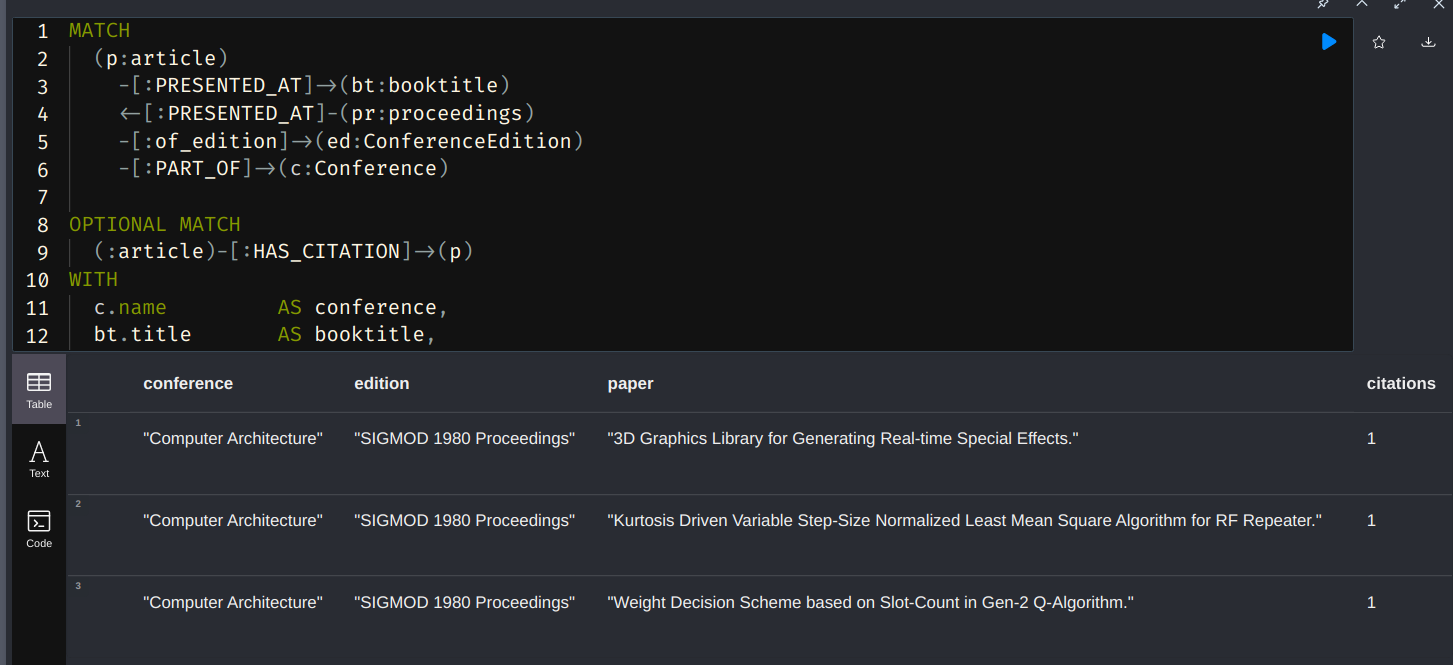

# 2. Conference Community

To make the following query as efficient as possible, we follow the procedure below. We first match the nodes affected during the traverse (the same as in the previous query, adding the author), and then match only the authors that have made an article publication to 4 different Editions of the same Conference. 

```bash
MATCH 
  (a:author)<-[:AUTHORED_BY]-(art:article)
  -[:PRESENTED_AT]->(bt:booktitle)
  <-[:PRESENTED_AT]-(pr:proceedings)
  -[:OF_EDITION]->(ed:ConferenceEdition)
  -[:PART_OF]->(c:Conference)
WITH 
  c.name             AS conference,
  a.name             AS author,
  count(DISTINCT ed) AS editionsCount
WHERE editionsCount >= 4
RETURN
  conference,
  author,
  editionsCount
ORDER BY
  conference,
  editionsCount DESC,
  author;


# 3. Impact Factor of journals

Before writing the query, lets recall how the calculation of an impact factor is copmuted. "In any given year, the two-year journal impact factor is the ratio between the number of citations received in that year for publications in that journal that were published in the two preceding years and the total number of "citable items" published in that journal during the two preceding years"

To be able to run this query, we first need to define a target year. To make the query as efficient as possible, we create a parameter that we can later change for another one and re run the query rapidly. The pipeline is as follows: 

Once we have defined the year and matched all journals, we proceed to first calculate how many papers were published during the two years previous to our target year. Afterwards, we proceed to count the number of citations made **in that year only**, to the articles published in the two previous years. Once we have both numerator and denominator, we can then calculate the result and return in nicely. 

```bash
// 1) set the target year
:param year => 2024;

// 2) compute impact factor per journal
MATCH (j:journal)
WITH j

// Denominator: count of articles the journal published in (year−2) and (year−1)
OPTIONAL MATCH (j)<-[:PUBLISHED_IN]-(p:article)
WHERE p.year IN [ $year - 2, $year - 1 ]
WITH j, count(p) AS numPapers

// Numerator: count of citations *made in $year* to those papers
OPTIONAL MATCH (j)<-[:PUBLISHED_IN]-(cited:article)<-[:HAS_CITATION]-(citer:article)
WHERE cited.year IN [ $year - 2, $year - 1 ]
  AND citer.year = $year
WITH j, numPapers, count(*) AS numCitations

// Final result: impact factor = numCitations / numPapers
WHERE numPapers > 0
RETURN
  j.name                AS journal,
  $year                 AS year,
  round(toFloat(numCitations) / numPapers, 3) AS impactFactor,
  numCitations,
  numPapers
ORDER BY impactFactor DESC;


# 4. H-Index of authors in the graph

Recall that the h-index of an author answers to the question “How many of my papers have at least that many citations?” If an authors h-index is 5, it means the author has 5 papers with over 5 citations. 

To perform this last query, we follow this procedure:

We first gather each author's articles and count how many incoming citation citation edges it has. To keep things organized, we collect those counts into a list and order it from highst to lowest, where the paper with the most citations is listed as 1. We do this so that later we can unwind the positions as indexes, and filter only those papers that have a higher citation number than its index (this is the definition of a h-index). To finish off, we get the highest index that passed the filter, via a max(idx). 

```bash
// 1) For every author, get their papers and citation counts
MATCH (a:author)<-[:AUTHORED_BY]-(p:article)
OPTIONAL MATCH (p)<-[:HAS_CITATION]-(:article)
WITH a, p, count(*) AS citations

// 2) Collect and sort the counts descending
ORDER BY a.name, citations DESC
WITH a, collect(citations) AS citationList

// 3) Unwind positions 1…N and keep those where citations ≥ position
UNWIND range(1, size(citationList)) AS idx
WITH a, idx, citationList[idx-1] AS citesAtIdx
WHERE citesAtIdx >= idx

// 4) The h‑index is the maximum such idx per author
RETURN
  a.name   AS author,
  max(idx) AS hIndex
ORDER BY hIndex DESC, author;
